<a href="https://colab.research.google.com/github/A01745336/Evidencia2_Detecci-nDePlagio/blob/main/ModeloClasificacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from zipfile import ZipFile
import os


In [ ]:
# Crear las carpetas necesarias
folders = ['insert_replace', 'shuffle', 'tense_change', 'voice_change', 'paraphrase']

for folder in folders:
    path = f'/content/documents/{folder}'
    if not os.path.exists(path):
        os.makedirs(path)

print("Carpetas creadas:")
!ls /content/documents


Carpetas creadas:
insert_replace	paraphrase  shuffle  tense_change  voice_change


In [ ]:
# Descomprimir el archivo en la carpeta de
zip_path = '/content/TextosOriginales.zip'
with ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/documents')

# Verificar los archivos descomprimidos
print("Documentos originales cargados:")
!ls /content/documents/original


Documentos originales cargados:
ls: cannot access '/content/documents/original': No such file or directory


In [ ]:
!pip install spacy
!python -m spacy download en_core_web_sm
!pip install pyinflect


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 42.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 703.5/703.5 kB 8.4 MB/s eta 0:00:00


In [ ]:
import spacy
import random
import nltk
from nltk.corpus import wordnet
import pyinflect

# Cargar el modelo de spaCy
nlp = spacy.load("en_core_web_sm")
nltk.download('wordnet')

def cambiar_tiempo(texto, num_palabras_modificar):
    doc = nlp(texto)
    texto_cambiado = []
    verbos_modificados = 0

    for sent in doc.sents:
        nueva_oracion = []
        for token in sent:
            if verbos_modificados >= num_palabras_modificar:
                nueva_oracion.append(token.text)
                continue

            nuevo_verbo = token.text
            if token.pos_ == 'VERB':
                # Cambiar presente simple a pasado simple y viceversa
                if token.tag_ in ['VB', 'VBP', 'VBZ']:  # Present simple
                    nuevo_verbo = token._.inflect('VBD')  # To Past simple
                elif token.tag_ == 'VBD':  # Past simple
                    nuevo_verbo = token._.inflect('VBP')  # To Present simple

                # Cambiar presente continuo a pasado continuo y viceversa
                elif token.tag_ == 'VBG':  # Present continuous
                    if token.head.tag_ in ['VBP', 'VBZ']:  # is/am/are
                        nuevo_verbo = token._.inflect('VBN')  # To past participle
                    else:
                        nuevo_verbo = token.text
                elif token.tag_ == 'VBN' and token.head.tag_ == 'VBD':  # Past participle used in past continuous
                    nuevo_verbo = token._.inflect('VBG')  # To present continuous

                # Manejar futuro simple
                elif token.tag_ == 'MD' and token.lower_ == 'will':  # Future simple 'will'
                    nuevo_verbo = 'would'
                elif token.tag_ == 'MD' and token.lower_ == 'would':  # Conditional 'would'
                    nuevo_verbo = 'will'

                if nuevo_verbo and nuevo_verbo != token.text:
                    verbos_modificados += 1

            nueva_oracion.append(nuevo_verbo if nuevo_verbo else token.text)

        texto_cambiado.append(' '.join(nueva_oracion))
    return ' '.join(texto_cambiado)

def parafrasear_documento(texto, num_palabras_modificar):
    palabras = texto.split()
    num_palabras = len(palabras)
    palabras_a_modificar = min(num_palabras, num_palabras_modificar)  # Asegurar que no excedemos el número de palabras disponibles

    indices_a_modificar = random.sample(range(num_palabras), palabras_a_modificar)

    texto_parafraseado = []
    for i, palabra in enumerate(palabras):
        if i in indices_a_modificar:
            sinonimos = [syn.lemmas()[0].name().replace('_', ' ') for syn in wordnet.synsets(palabra)]
            sinonimo = random.choice(sinonimos) if sinonimos else palabra
            texto_parafraseado.append(sinonimo)
        else:
            texto_parafraseado.append(palabra)

    return ' '.join(texto_parafraseado)

def insertar_o_reemplazar_frases(texto, num_oraciones_modificar, insertar=True):
    doc = nlp(texto)
    oraciones = list(doc.sents)
    num_oraciones = len(oraciones)
    oraciones_a_modificar = max(1, num_oraciones_modificar)  # Asumiendo que ya viene calculado como porcentaje

    oraciones_seleccionadas = random.sample(oraciones, min(oraciones_a_modificar, num_oraciones))

    if insertar:
        for oracion in oraciones_seleccionadas:
            pos = random.randint(0, num_oraciones)
            oraciones.insert(pos, oracion)
    else:
        indices_a_reemplazar = random.sample(range(num_oraciones), min(oraciones_a_modificar, num_oraciones))
        for idx in indices_a_reemplazar:
            oraciones[idx] = random.choice(oraciones_seleccionadas)

    return ' '.join(oracion.text for oracion in oraciones)


def desordenar_frases(texto, num_oraciones_modificar):
    doc = nlp(texto)
    oraciones = list(doc.sents)
    num_oraciones = len(oraciones)
    oraciones_a_desordenar = max(1, num_oraciones_modificar)  # Asumiendo que ya viene calculado como porcentaje

    oraciones_seleccionadas = random.sample(oraciones, min(oraciones_a_desordenar, num_oraciones))
    random.shuffle(oraciones_seleccionadas)

    indices_seleccionados = random.sample(range(num_oraciones), min(oraciones_a_desordenar, num_oraciones))
    for indice, oracion in zip(indices_seleccionados, oraciones_seleccionadas):
        oraciones[indice] = oracion

    return ' '.join(oracion.text for oracion in oraciones)


def cambiar_voz(texto, num_oraciones_modificar):
    doc = nlp(texto)
    oraciones = list(doc.sents)
    num_oraciones = len(oraciones)
    oraciones_a_modificar = max(1, num_oraciones_modificar)  # Asumiendo que ya viene calculado como porcentaje

    indices_a_modificar = random.sample(range(num_oraciones), min(oraciones_a_modificar, num_oraciones))
    texto_cambiado = []

    for i, oracion in enumerate(oraciones):
        if i in indices_a_modificar:
            sujeto = ""
            verbo = ""
            objeto = ""
            for token in oracion:
                if token.dep_ == 'nsubj':
                    sujeto = token.text
                elif token.dep_ == 'dobj':
                    objeto = token.text
                elif token.pos_ == 'VERB':
                    verbo = token.lemma_
            if sujeto and objeto:
                nueva_oracion = f"{objeto} was {verbo}ed by {sujeto}"
                texto_cambiado.append(nueva_oracion)
            else:
                texto_cambiado.append(oracion.text)
        else:
            texto_cambiado.append(oracion.text)

    return ' '.join(texto_cambiado)


[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
import random

def aplicar_plagio_y_guardar(documento, filename, tecnica):
    texto = documento
    num_palabras = len(texto.split())

    porcentaje = random.randint(20, 100)
    num_palabras_modificar = int(num_palabras * porcentaje / 100)

    if tecnica == "insert_replace":
      texto = insertar_o_reemplazar_frases(texto, num_palabras_modificar // 10)  # Asumiendo que cada frase tiene ~10 palabras
    elif tecnica == "shuffle":
      texto = desordenar_frases(texto, num_palabras_modificar)
    elif tecnica == "tense_change":
      texto = cambiar_tiempo(texto, num_palabras_modificar)
    elif tecnica == "voice_change":
      texto = cambiar_voz(texto, num_palabras_modificar)
    elif tecnica == "paraphrase":
      texto = parafrasear_documento(texto, num_palabras_modificar)

    filename = str(porcentaje) + "_" + filename
    path_guardado = f'/content/documents/{"".join(tecnica)}/{filename}'
    if not os.path.exists(os.path.dirname(path_guardado)):
        os.makedirs(os.path.dirname(path_guardado))
    with open(path_guardado, 'w', encoding='utf-8') as file:
        file.write(texto)


In [ ]:
import os

# Directorio donde están guardados los documentos originales
dir_originales = '/content/documents/TextosOriginales'

# Técnicas de plagio disponibles
tecnicas_disponibles = ["insert_replace", "shuffle", "tense_change", "voice_change", "paraphrase"]

# Procesar cada documento en el directorio
for filename in os.listdir(dir_originales):
    if filename.endswith('.txt'):  # Asegúrate de que sean documentos de texto
        filepath = os.path.join(dir_originales, filename)

        # Leer el contenido del documento
        try:
          with open(filepath, 'r', encoding='utf-8') as file:
              content = file.read()
        except UnicodeDecodeError:
          with open(filepath, 'r', encoding='windows-1252') as file:
              content = file.read()

        for i in range(1, 4):
          # Generar nombre para el archivo modificado
          new_filename = f'plagiarized_insert_replace_{i}_{filename}'
          # Aplicar plagio y guardar el resultado
          aplicar_plagio_y_guardar(content, new_filename, "insert_replace")

          # Generar nombre para el archivo modificado
          new_filename = f'plagiarized_shuffle_{i}_{filename}'
          # Aplicar plagio y guardar el resultado
          aplicar_plagio_y_guardar(content, new_filename, "shuffle")

          # Generar nombre para el archivo modificado
          new_filename = f'plagiarized_tense_change_{i}_{filename}'
          # Aplicar plagio y guardar el resultado
          aplicar_plagio_y_guardar(content, new_filename, "tense_change")

          # Generar nombre para el archivo modificado
          new_filename = f'plagiarized_voice_change_{i}_{filename}'
          # Aplicar plagio y guardar el resultado
          aplicar_plagio_y_guardar(content, new_filename, "voice_change")


          # Generar nombre para el archivo modificado
          new_filename = f'plagiarized_paraphrase_{i}_{filename}'
          # Aplicar plagio y guardar el resultado
          aplicar_plagio_y_guardar(content, new_filename, "paraphrase")



In [ ]:
import os
import shutil

# Rutas de las carpetas de origen
folders = [
    "/content/documents/insert_replace",
    "/content/documents/paraphrase",
    "/content/documents/shuffle",
    "/content/documents/tense_change",
    "/content/documents/voice_change"
]

# Ruta de la carpeta de destino
destination_folder = "/content/documents/TextosPlagio"
os.makedirs(destination_folder, exist_ok=True)  # Crea la carpeta si no existe

for folder in folders:
    for filename in os.listdir(folder):
        source_path = os.path.join(folder, filename)
        destination_path = os.path.join(destination_folder, filename)
        shutil.copy(source_path, destination_path)  # Copia cada archivo

num_files = len(os.listdir(destination_folder))
print(f"Total de archivos en 'TextosPlagio': {num_files}")

Total de archivos en 'TextosPlagio': 1650


In [ ]:
import os
import string
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import BertTokenizer, BertModel
import joblib

# Inicializar el tokenizador y el modelo BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

def read_files_in_directory(directory):
    files_contents = []
    file_names = []
    for filename in os.listdir(directory):
        if filename.endswith('.txt'):
            file_path = os.path.join(directory, filename)
            try:
                with open(file_path, 'r', encoding='utf-8') as file:
                    files_contents.append(file.read())
            except UnicodeDecodeError:
                with open(file_path, 'r', encoding='windows-1252') as file:
                    files_contents.append(file.read())
            file_names.append(filename)
    return file_names, files_contents

def preprocess_for_bert(text):
    text = text.lower()  # Optativo, remover si usas BERT cased
    return text  # Se elimina la eliminación de puntuación para preservar el contexto natural para BERT

def bert_embeddings(text):
    inputs = tokenizer(text, return_tensors='pt', max_length=512, truncation=True, padding='max_length')
    outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().detach().numpy()

def generate_vector_space_models(texts):
    vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1, 3))
    processed_texts = [preprocess_for_bert(text) for text in texts]
    bert_embeddings_texts = np.array([bert_embeddings(text) for text in processed_texts])

    tfidf_matrix_texts = vectorizer.fit_transform(processed_texts)  # Asegurarse de ajustar el vectorizador
    combined_features_texts = np.hstack([tfidf_matrix_texts.toarray(), bert_embeddings_texts])

    # Guardar el vectorizador ajustado
    joblib.dump(vectorizer, 'tfidf_vectorizer.joblib')

    return combined_features_texts


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
# Leer los archivos de texto
directory_path = '/content/documents/TextosPlagio'  # Asegúrate de ajustar la ruta según tus necesidades
file_names, files_contents = read_files_in_directory(directory_path)

# Generar las características combinadas (TF-IDF + BERT Embeddings)
combined_features = generate_vector_space_models(files_contents)


In [ ]:
import os

def extract_labels_from_filenames(file_names):
    labels = []
    for name in file_names:
        if 'insert_replace' in name:
            labels.append('insert_replace')
        elif 'paraphrase' in name:
            labels.append('paraphrase')
        elif 'shuffle' in name:
            labels.append('shuffle')
        elif 'tense_change' in name:
            labels.append('tense_change')
        elif 'voice_change' in name:
            labels.append('voice_change')
        else:
            labels.append('unknown')  # en caso de que haya algún archivo que no coincida
    return labels

# Ejemplo de uso
directory_path = '/content/documents/TextosPlagio'  # Asegúrate de ajustar la ruta según tus necesidades
file_names, files_contents = read_files_in_directory(directory_path)
labels = extract_labels_from_filenames(file_names)
print(file_names[0:10])
print(labels[0:10])
print(len(labels))

['88_plagiarized_shuffle_2_org-077.txt', '30_plagiarized_insert_replace_3_org-064.txt', '74_plagiarized_shuffle_1_org-023.txt', '31_plagiarized_voice_change_1_org-073.txt', '72_plagiarized_insert_replace_3_org-109.txt', '86_plagiarized_shuffle_2_org-073.txt', '93_plagiarized_tense_change_2_org-072.txt', '32_plagiarized_insert_replace_2_org-045.txt', '54_plagiarized_insert_replace_1_org-038.txt', '50_plagiarized_shuffle_1_org-044.txt']
['shuffle', 'insert_replace', 'shuffle', 'voice_change', 'insert_replace', 'shuffle', 'tense_change', 'insert_replace', 'insert_replace', 'shuffle']
1650


In [ ]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Codificar las etiquetas textuales a etiquetas numéricas
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(labels)

# Convertir las etiquetas numéricas a one-hot
one_hot_encoded_labels = to_categorical(integer_encoded)

# Ahora one_hot_encoded_labels puede ser usado como las etiquetas en el entrenamiento de la red


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import Adam

# Número de características de entrada
input_dim = combined_features.shape[1]  # Asumiendo que combined_features es tu conjunto de datos de entrada
# Número de clases
num_classes = one_hot_encoded_labels.shape[1]

model = Sequential([
    Dense(256, activation='relu', input_shape=(input_dim,), kernel_regularizer=l1_l2(l1=0.001, l2=0.001)),
    Dropout(0.2),  # Reducido desde 0.5
    Dense(128, activation='relu', kernel_regularizer=l1_l2(l1=0.001, l2=0.001)),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])


model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])



In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint

# Define el checkpoint para guardar el mejor modelo basado en 'val_accuracy'
checkpoint_path = 'best_model.h5'  # Define la ruta donde se guardará el mejor modelo
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)

# Dividir los datos en entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(combined_features, one_hot_encoded_labels, test_size=0.2, random_state=42)

# Entrenar el modelo incluyendo el checkpoint en la lista de callbacks
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[model_checkpoint]  # Añadir el checkpoint aquí
)



Epoch 1/20
20/21 [===========================>..] - ETA: 0s - loss: 2.6589 - accuracy: 0.7609
Epoch 1: val_accuracy improved from -inf to 0.83030, saving model to best_model.h5
21/21 [==============================] - 7s 354ms/step - loss: 2.6565 - accuracy: 0.7629 - val_loss: 2.6125 - val_accuracy: 0.8303
Epoch 2/20
20/21 [===========================>..] - ETA: 0s - loss: 2.6067 - accuracy: 0.7742
Epoch 2: val_accuracy improved from 0.83030 to 0.83333, saving model to best_model.h5
21/21 [==============================] - 14s 690ms/step - loss: 2.6062 - accuracy: 0.7735 - val_loss: 2.5678 - val_accuracy: 0.8333
Epoch 3/20
21/21 [==============================] - ETA: 0s - loss: 2.5609 - accuracy: 0.7705
Epoch 3: val_accuracy did not improve from 0.83333
21/21 [==============================] - 1s 31ms/step - loss: 2.5609 - accuracy: 0.7705 - val_loss: 2.5224 - val_accuracy: 0.8242
Epoch 4/20
19/21 [==========================>...] - ETA: 0s - loss: 2.5209 - accuracy: 0.7747
Epoch 4: va

In [ ]:
from tensorflow.keras.models import load_model

# Cargar el mejor modelo guardado
best_model = load_model(checkpoint_path)

# Evaluar el mejor modelo en el conjunto de validación
loss, accuracy = best_model.evaluate(X_val, y_val)
print(f"Best Model Validation Accuracy: {accuracy*100:.2f}%")



11/11 [==============================] - 0s 12ms/step - loss: 1.9521 - accuracy: 0.8576
Best Model Validation Accuracy: 85.76%


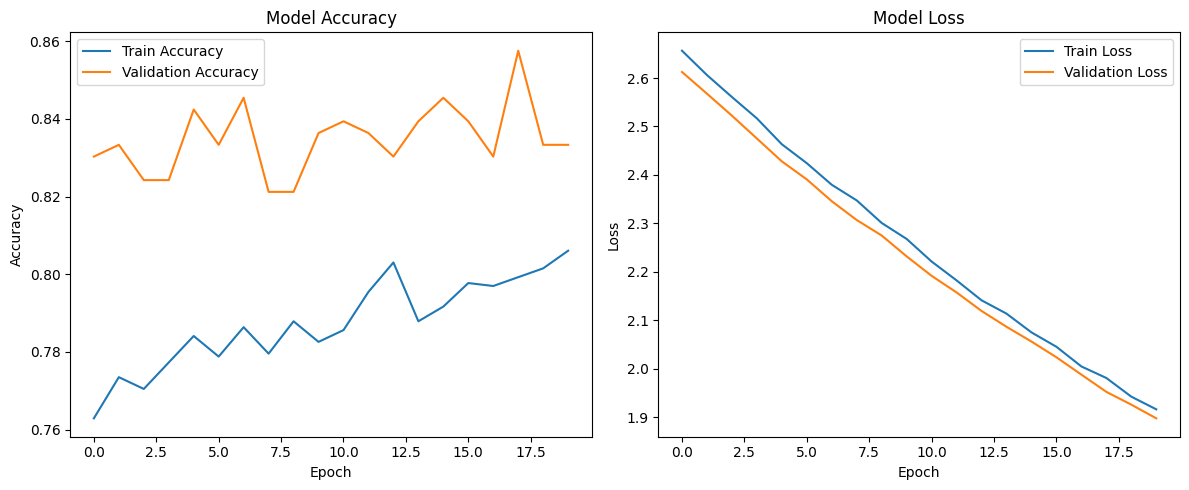

In [ ]:
import matplotlib.pyplot as plt

# Resumen de precisión y pérdida durante el entrenamiento
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Descomprimir el archivo en la carpeta de
zip_path = '/content/OneDrive_2024-05-02.zip'
with ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/documents')

In [ ]:
import os
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import BertTokenizer, BertModel
import joblib

# Cargar los componentes previamente ajustados
tfidf_vectorizer = joblib.load('tfidf_vectorizer (2).joblib')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

def read_files_in_directory(directory):
    files_contents = []
    file_names = []
    for filename in os.listdir(directory):
        if filename.endswith('.txt'):
            file_path = os.path.join(directory, filename)
            with open(file_path, 'r', encoding='utf-8') as file:
                files_contents.append(file.read())
            file_names.append(filename)
    return file_names, files_contents

def preprocess_text(text):
    return text.lower()  # Simplified preprocessing

def bert_embeddings(text):
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512)
    outputs = bert_model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().detach().numpy()

def generate_vector_space_models(directory_path):
    file_names, texts = read_files_in_directory(directory_path)
    processed_texts = [preprocess_text(text) for text in texts]
    tfidf_features = tfidf_vectorizer.transform(processed_texts).toarray()
    bert_features = np.array([bert_embeddings(text) for text in processed_texts])
    combined_features = np.hstack([tfidf_features, bert_features])
    return file_names, combined_features


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
def predict_plagiarism_types(features, model):
    predictions = model.predict(features)
    predicted_classes = np.argmax(predictions, axis=1)
    return predicted_classes


In [ ]:
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Define la ruta a la carpeta con documentos
directory_path = '/content/documents/FinalTesting'

# Cargar el modelo
model = load_model('best_model (3).h5')

labels = ['insert_replace', 'paraphrase', 'shuffle', 'tense_change', 'voice_change']
# Codificar las etiquetas textuales a etiquetas numéricas
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(labels)

# Convertir las etiquetas numéricas a one-hot
one_hot_encoded_labels = to_categorical(integer_encoded)

# Generar las características combinadas (TF-IDF + BERT Embeddings)
file_names, features = generate_vector_space_models(directory_path)

# Crear un diccionario para mapear de índices a etiquetas textuales
index_to_label = {index: label for index, label in enumerate(label_encoder.classes_)}

# Predecir tipos de plagio
predictions = predict_plagiarism_types(features, model)

# Predicción (suponiendo que `predictions` contiene índices numéricos)
predicted_labels = [index_to_label[pred] for pred in predictions]

# Mostrar resultados con etiquetas textuales
for file_name, predicted_label in zip(file_names, predicted_labels):
    print(f"File: {file_name}, Predicted Plagiarism Type: {predicted_label}")



1/1 [==============================] - 0s 279ms/step
File: FID-002.txt, Predicted Plagiarism Type: shuffle
File: FID-020.txt, Predicted Plagiarism Type: shuffle
File: FID-026.txt, Predicted Plagiarism Type: insert_replace
File: FID-007.txt, Predicted Plagiarism Type: tense_change
File: FID-009.txt, Predicted Plagiarism Type: shuffle
File: FID-024.txt, Predicted Plagiarism Type: insert_replace
File: FID-019.txt, Predicted Plagiarism Type: shuffle
File: FID-016.txt, Predicted Plagiarism Type: shuffle
File: FID-018.txt, Predicted Plagiarism Type: insert_replace
File: FID-030.txt, Predicted Plagiarism Type: shuffle
File: FID-023.txt, Predicted Plagiarism Type: shuffle
File: FID-025.txt, Predicted Plagiarism Type: shuffle
File: FID-011.txt, Predicted Plagiarism Type: shuffle
File: FID-005.txt, Predicted Plagiarism Type: shuffle
File: FID-028.txt, Predicted Plagiarism Type: shuffle
File: FID-004.txt, Predicted Plagiarism Type: shuffle
File: FID-012.txt, Predicted Plagiarism Type: insert_repl